In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'DejaVu Sans Mono'
input_path = '../../input'

In [2]:
col_names = [
    'cap-shape', 'cap-surface', 'cap-color', 'bruises?', 'odor', 
    'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color', 'stalk-shape',
    'stalk-root', 'stalk-surface-above-ring', 'stalk-surface-below-ring', 'stalk-color-above-ring', 'stalk-color-below-ring',
    'veil-type', 'veil-color', 'ring-number', 'ring-type', 'spore-print-color',
    'population', 'habitat'
]
feature_names = col_names[1:]
df = pd.read_csv(f'{input_path}/agaricus-lepiota.data', names=['edibility']+col_names)

In [3]:
df.head()

,edibility,cap-shape,cap-surface,cap-color,bruises?,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


In [4]:
df.isna().sum()

edibility                   0
cap-shape                   0
cap-surface                 0
cap-color                   0
bruises?                    0
odor                        0
gill-attachment             0
gill-spacing                0
gill-size                   0
gill-color                  0
stalk-shape                 0
stalk-root                  0
stalk-surface-above-ring    0
stalk-surface-below-ring    0
stalk-color-above-ring      0
stalk-color-below-ring      0
veil-type                   0
veil-color                  0
ring-number                 0
ring-type                   0
spore-print-color           0
population                  0
habitat                     0
dtype: int64

In [5]:
from sklearn.model_selection import train_test_split

_, test_idxs = train_test_split(df.index, test_size=0.2, stratify=df['edibility'], random_state=42)
test_mask = df.index.isin(test_idxs)

In [6]:
df['edibility'].value_counts()

e    4208
p    3916
Name: edibility, dtype: int64

In [7]:
df_train = df[~test_mask]
df_test = df[test_mask]

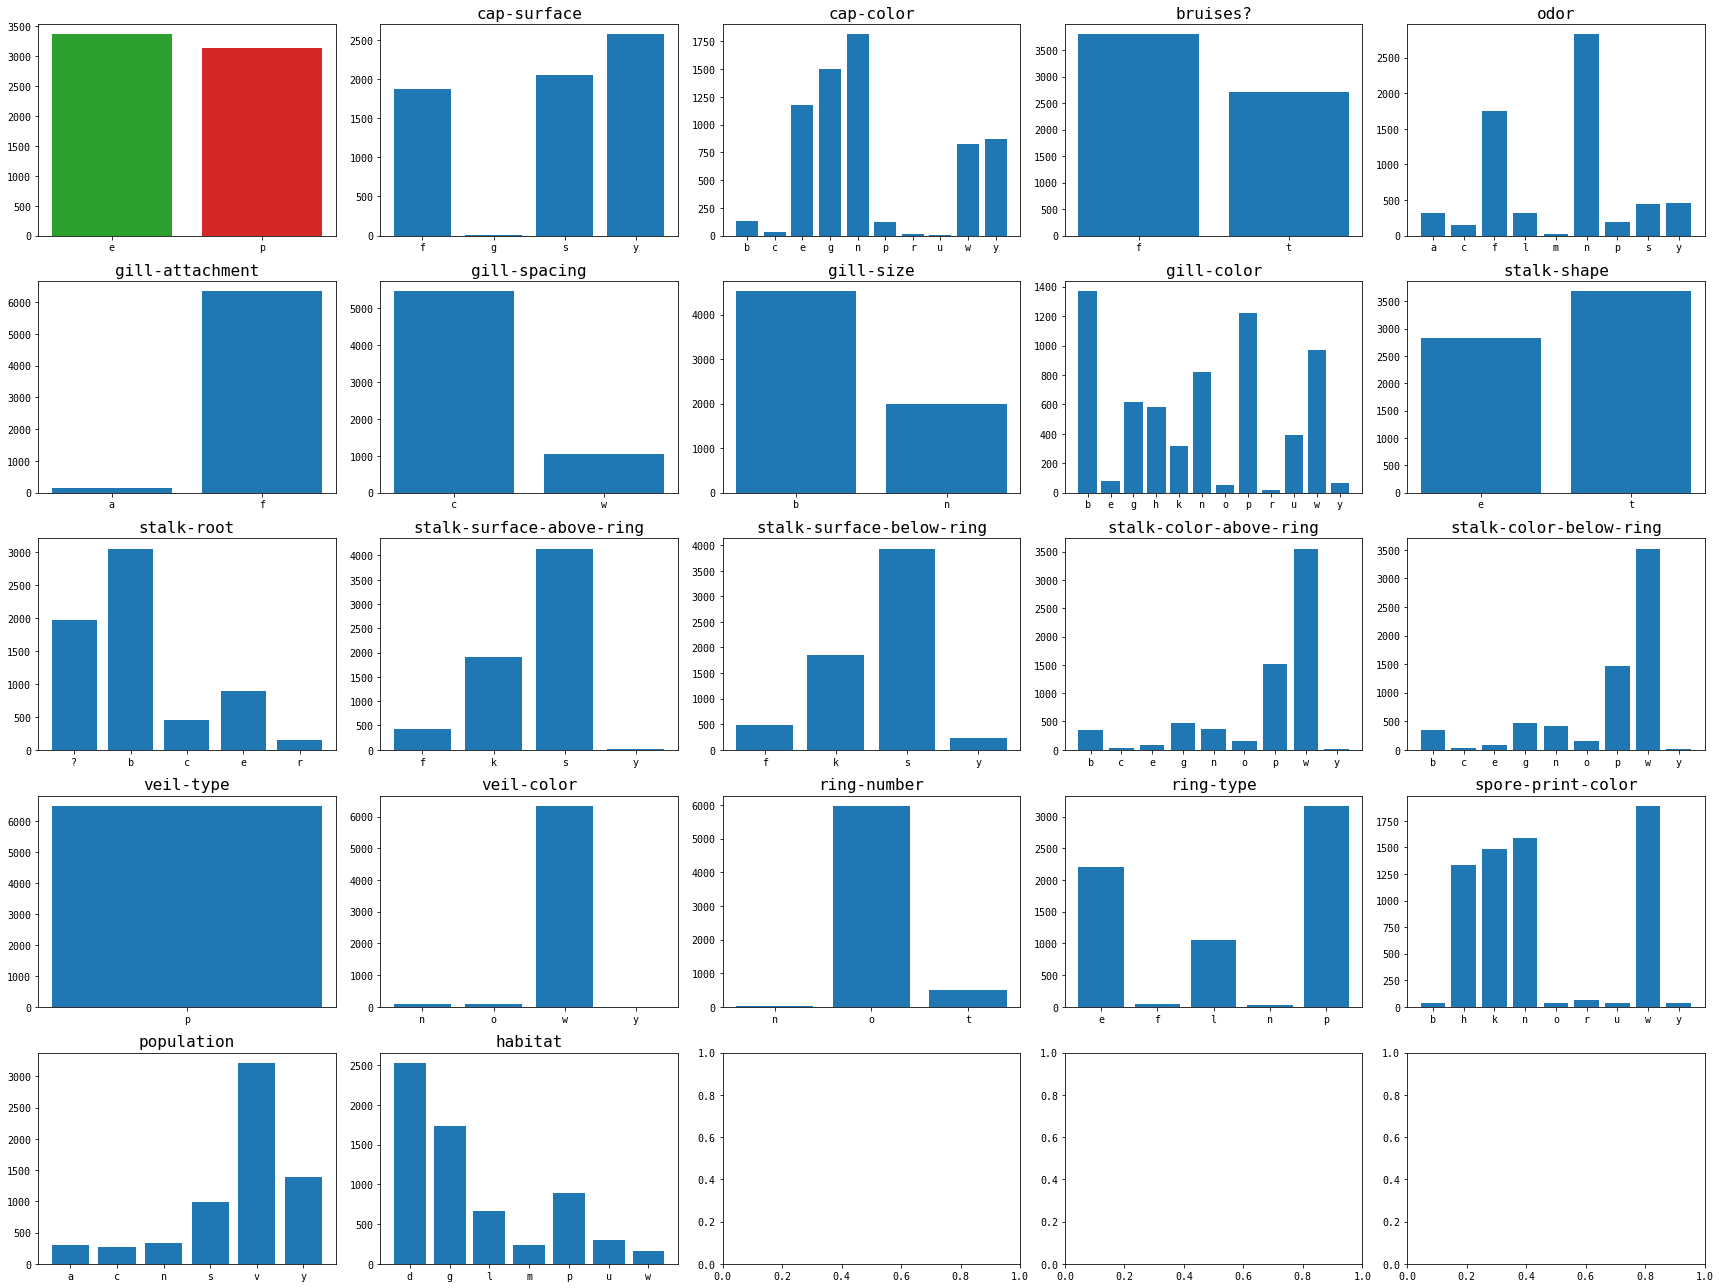

In [8]:
fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(24, 18))
axs = axs.ravel()
ax = axs[0]
ax.bar(['e', 'p'], [(df_train['edibility'] == 'e').sum(), 0], color='C2')
ax.bar(['e', 'p'], [0, (df_train['edibility'] == 'p').sum()], color='C3')
for i in range(1, 22):
    ax = axs[i]
    ser = df_train[col_names[i]].value_counts().sort_index()
    ax.bar(ser.index, ser, color=f'C{3*int(i==0)}')
    ax.set_title(col_names[i], fontsize=16)
plt.tight_layout(), plt.show(); plt.close()

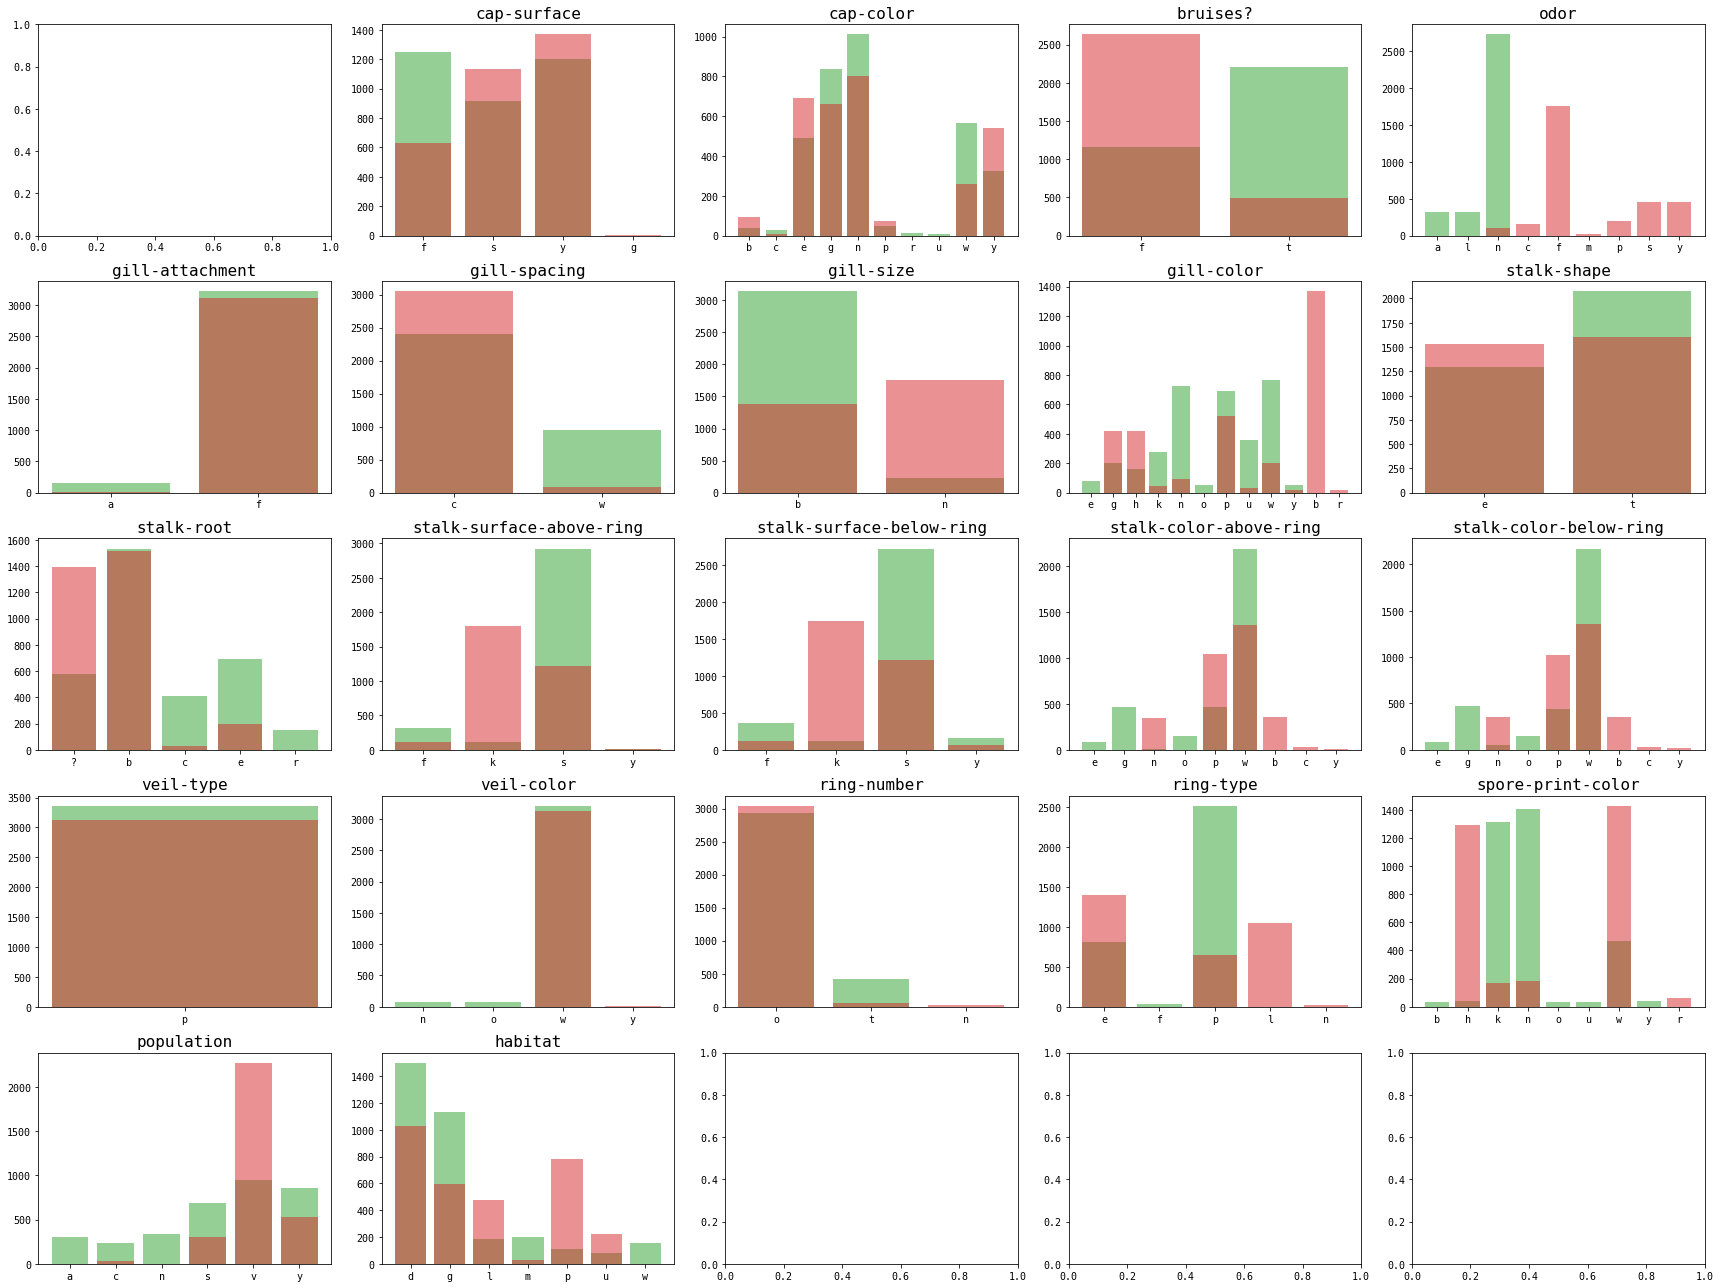

In [9]:
fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(24, 18))
axs = axs.ravel()
for i in range(1, 22):
    ax = axs[i]
    ser = df_train.loc[df_train['edibility'] == 'e', col_names[i]].value_counts().sort_index()
    ax.bar(ser.index, ser, color=f'C2', alpha=0.5)

    ser = df_train.loc[df_train['edibility'] == 'p', col_names[i]].value_counts().sort_index()
    ax.bar(ser.index, ser, color=f'C3', alpha=0.5)
    ax.set_title(col_names[i], fontsize=16)
plt.tight_layout(), plt.show(); plt.close()

In [10]:
from scipy.stats import chi2_contingency
import itertools

cramer_v = np.zeros((len(col_names), len(col_names)))

for name1, name2 in itertools.product(col_names, col_names):
    if name1 == 'veil-type' or name2 == 'veil-type':
        continue
    chi2, _, _, _ = chi2_contingency(pd.crosstab(df_train[name1], df_train[name2]))
    v = np.sqrt(chi2 / (min(df_train[name1].nunique(), df_train[name2].nunique())-1) / df_train.shape[0])
    cramer_v[col_names.index(name1), col_names.index(name2)] = v
    cramer_v[col_names.index(name2), col_names.index(name1)] = v

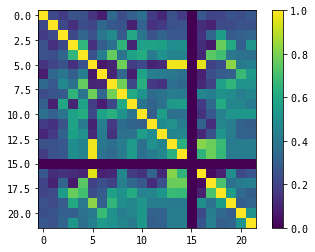

In [11]:
img = plt.imshow(cramer_v)
plt.colorbar(img)

2nd

In [12]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score


X_train, X_test = df_train[col_names], df_test[col_names]
y_train, y_test = df_train['edibility'], df_test['edibility']

model = make_pipeline(
    OneHotEncoder(
        sparse=False
    ),
    LogisticRegression(
        max_iter=1000,
        random_state=42
    )
)
model.fit(X_train, y_train)

print(accuracy_score(y_train, model.predict(X_train)))
print(accuracy_score(y_test, model.predict(X_test)))

0.9998461301738729
0.9993846153846154


In [13]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score


X_train, X_test = df_train[col_names], df_test[col_names]
y_train, y_test = df_train['edibility'], df_test['edibility']

model = make_pipeline(
    OneHotEncoder(
        sparse=False
    ),
    SVC(
        random_state=42
    )
)
model.fit(X_train, y_train)

print(accuracy_score(y_train, model.predict(X_train)))
print(accuracy_score(y_test, model.predict(X_test)))

1.0
1.0


How to interpret tree classifier

In [27]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score


X_train, X_test = df_train[col_names], df_test[col_names]
y_train, y_test = df_train['edibility'], df_test['edibility']

model = make_pipeline(
    OneHotEncoder(
        sparse=False
    ),
    DecisionTreeClassifier(
        random_state=42
    )
)
model.fit(X_train, y_train)

print(accuracy_score(y_train, model.predict(X_train)))
print(accuracy_score(y_test, model.predict(X_test)))

1.0
1.0


1. cap-shape: bell=b,conical=c,convex=x,flat=f, knobbed=k,sunken=s
2. cap-surface: fibrous=f,grooves=g,scaly=y,smooth=s
3. cap-color: brown=n,buff=b,cinnamon=c,gray=g,green=r, pink=p,purple=u,red=e,white=w,yellow=y
4. bruises?: bruises=t,no=f
5. odor: almond=a,anise=l,creosote=c,fishy=y,foul=f, musty=m,none=n,pungent=p,spicy=s
6. gill-attachment: attached=a,descending=d,free=f,notched=n
7. gill-spacing: close=c,crowded=w,distant=d
8. gill-size: broad=b,narrow=n
9. gill-color: black=k,brown=n,buff=b,chocolate=h,gray=g, green=r,orange=o,pink=p,purple=u,red=e, white=w,yellow=y
10. stalk-shape: enlarging=e,tapering=t
11. stalk-root: bulbous=b,club=c,cup=u,equal=e, rhizomorphs=z,rooted=r,missing=?
12. stalk-surface-above-ring: fibrous=f,scaly=y,silky=k,smooth=s
13. stalk-surface-below-ring: fibrous=f,scaly=y,silky=k,smooth=s
14. stalk-color-above-ring: brown=n,buff=b,cinnamon=c,gray=g,orange=o, pink=p,red=e,white=w,yellow=y
15. stalk-color-below-ring: brown=n,buff=b,cinnamon=c,gray=g,orange=o, pink=p,red=e,white=w,yellow=y
16. veil-type: partial=p,universal=u
17. veil-color: brown=n,orange=o,white=w,yellow=y
18. ring-number: none=n,one=o,two=t
19. ring-type: cobwebby=c,evanescent=e,flaring=f,large=l, none=n,pendant=p,sheathing=s,zone=z
20. spore-print-color: black=k,brown=n,buff=b,chocolate=h,green=r, orange=o,purple=u,white=w,yellow=y
21. population: abundant=a,clustered=c,numerous=n, scattered=s,several=v,solitary=y
22. habitat: grasses=g,leaves=l,meadows=m,paths=p, urban=u,waste=w,woods=d

In [82]:
onehot_features = [
    [('bell', 'b'), ('conical', 'c'), ('convex', 'x'), ('flat', 'f'), ('knobbed', 'k'), ('sunken', 's')], 
    [('fibrous', 'f'), ('grooves', 'g'), ('scaly', 'y'), ('smooth', 's')], 
    [('brown', 'n'), ('buff', 'b'), ('cinnamon', 'c'), ('gray', 'g'), ('green', 'r'), ('pink', 'p'), ('purple', 'u'), 
    ('red', 'e'), ('white', 'w'), ('yellow', 'y')], 
    [('bruises', 't'), ('no bruises', 'f')],
    [('almond', 'a'), ('anise', 'l'), ('creosote', 'c'), ('fishy', 'y'), ('foul', 'f'), ('musty', 'm'), ('none', 'n'), 
    ('pungent', 'p'), ('spicy', 's')], 
    [('attached', 'a'), ('descending', 'd'), ('free', 'f'), ('notched', 'n')], 
    [('close', 'c'), ('crowded', 'w'), ('distant', 'd')], 
    [('broad', 'b'), ('narrow', 'n')],
    [('black', 'k'), ('brown', 'n'), ('buff', 'b'), ('chocolate', 'h'), ('gray', 'g'), ('green', 'r'), ('orange', 'o'), 
    ('pink', 'p'), ('purple', 'u'), ('red', 'e'), ('white', 'w'), ('yellow', 'y')], 
    [('enlarging', 'e'), ('tapering', 't')], 
    [('bulbous', 'b'), ('club', 'c'), ('cup', 'u'), ('equal', 'e'), ('rhizomorphus', 'z'), ('rooted', 'r'), ('missing', '?')],
    [('fibrous', 'f'), ('scaly', 'y'), ('silky', 'k'), ('smooth', 's')],
    [('fibrous', 'f'), ('scaly', 'y'), ('silky', 'k'), ('smooth', 's')],
    [('brown', 'n'), ('buff', 'b'), ('cinnamon', 'c'), ('gray', 'g'), ('orange', 'o'), ('pink', 'p'), ('red', 'e'),
    ('white', 'w'), ('yellow', 'y')],
    [('brown', 'n'), ('buff', 'b'), ('cinnamon', 'c'), ('gray', 'g'), ('orange', 'o'), ('pink', 'p'), ('red', 'e'),
    ('white', 'w'), ('yellow', 'y')],
    [('partial', 'p'), ('universal', 'u')], 
    [('brown', 'n'), ('orange', 'o'), ('white', 'w'), ('yellow', 'y')], 
    [('none', 'n'), ('one', 'o'), ('two', 't')], 
    [('cobwebby', 'c'), ('evanescent', 'e'), ('flaring', 'f'), ('large', 'l'), ('none', 'n'), ('pendant', 'p'), 
    ('sheathing', 's'), ('zone', 'z')],
    [('black', 'k'), ('brown', 'n'), ('buff', 'b'), ('chocolate', 'h'), ('green', 'r'), ('orange', 'o'), 
    ('purple', 'u'), ('white', 'w'), ('yellow', 'y')], 
    [('abundant', 'a'), ('clustered', 'c'), ('numerous', 'n'), ('scattered', 's'), ('several', 'v'), ('solitary', 'y')],
    [('grasses', 'g'), ('leavesl', 'l'), ('meadows', 'm'), ('paths', 'p'), ('urban', 'u'), ('waste', 'w'), ('woods', 'd')]
]
query_msg_fmts = [
    'Is cap shape {x}?',
    'Is cap surface {x}?',
    'Is cap color {x}?', 
    'Are there bruises? {x}', 
    'Is odor {x}?', 
    'Is gill {x}?', 
    'Is gill spacing {x}?',
    'Is gill size {x}?',
    'Is gill color {x}?', 
    'Is stalk shape {x}?', 
    'Is stalk root {x}?', 
    'Is stalk surface above ring {x}?',
    'Is stalk surface below ring {x}?', 
    'Is stalk color above ring {x}?', 
    'Is stalk color below ring {x}?', 
    'Is veil type {x}?', 
    'Is veil color {x}?', 
    'Is ring number {x}?', 
    'Is ring type {x}?', 
    'Is spore print color {x}?', 
    'Is it {x}?',
    'Is it inhabitant in {x}?'
]

In [70]:
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score

X_train, X_test = df_train[col_names], df_test[col_names]
y_train, y_test = df_train['edibility'], df_test['edibility']

model = make_pipeline(
    OneHotEncoder(
        categories=[[el[1] for el in lst] for lst in onehot_features],
        sparse=False
    ),
    FunctionTransformer(lambda x:1-x),
    DecisionTreeClassifier(
        random_state=42
    )
)
model.fit(X_train, y_train)

print(accuracy_score(y_train, model.predict(X_train)))
print(accuracy_score(y_test, model.predict(X_test)))

1.0
1.0


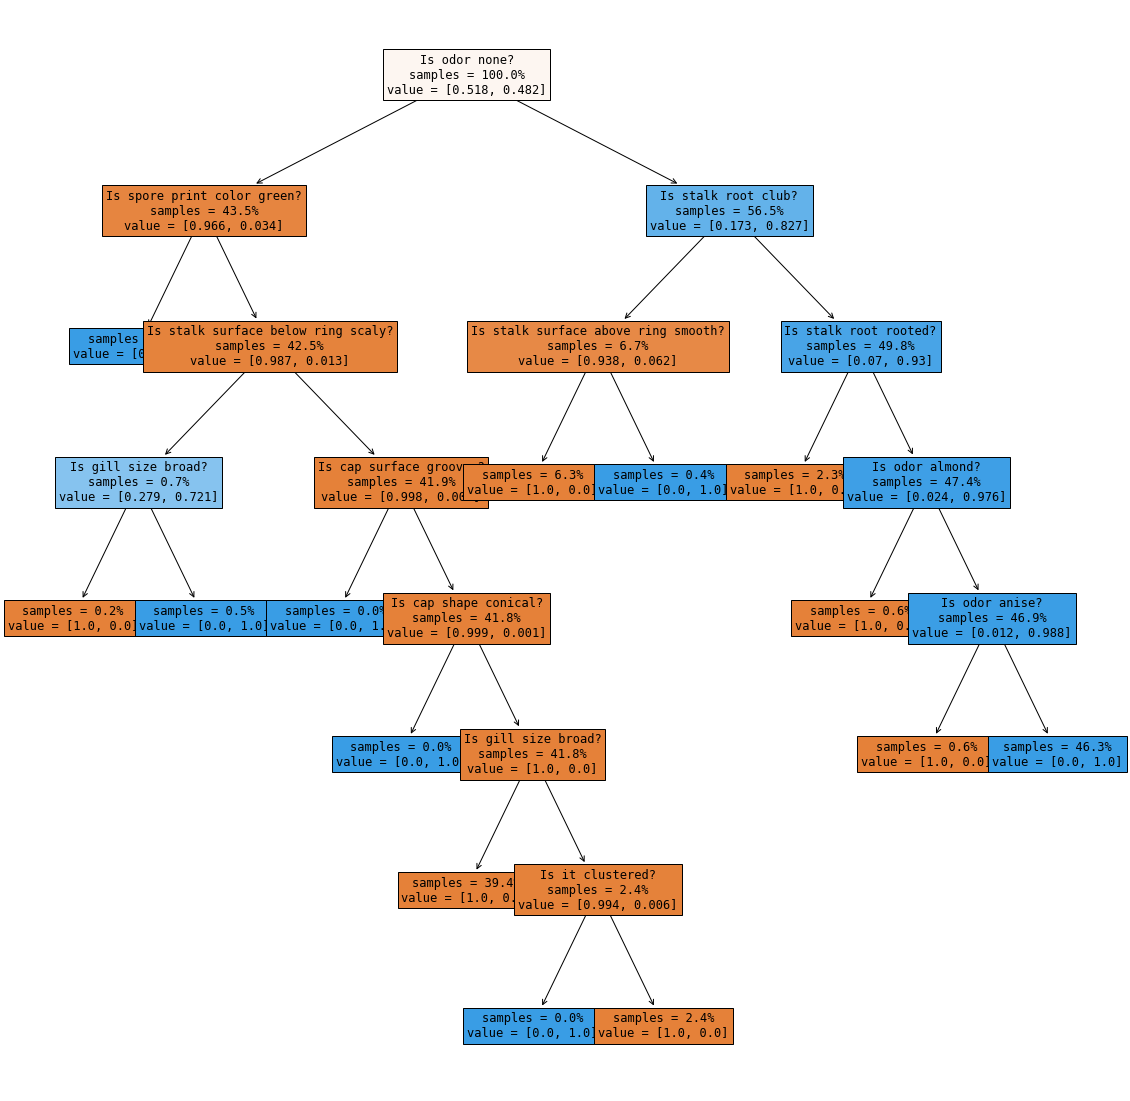

In [93]:
from functools import reduce

query_msgs = reduce(lambda x, y: x+y, ([fmt.format(x=el[0]) for el in lst] for fmt, lst in zip(query_msg_fmts, onehot_features)))
plt.figure(figsize=(20, 20))
annots = plot_tree(
    model[-1], 
    # feature_names=reduce(lambda x, y: x+y, [[el[0] for el in lst] for lst in onehot_features]),
    filled=True,
    impurity=False,
    proportion=True,
    fontsize=12
)
for annot in annots:
    txt = annot.get_text()
    if '<= 0.5' in txt:
        i = txt.split('\n')[0].split(']')[0].split('[')[1]
        i = int(i)
        annot.update({'text': txt.replace(txt.split('\n')[0], query_msgs[i])})
plt.show(); plt.close()